# Plot total melt flux, parent melt, child melt, etc for either hemisphere

In [1]:
#!conda activate gfdl
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xesmf
import pandas as pd
import netCDF4 as nc
import gfdlvitals
import matplotlib.pyplot as plt
import os
import pandas as pd
import copy
import time
from matplotlib.figure import figaspect
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.mpl.ticker as ctk
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
_ = xr.set_options(display_style='text')

In [2]:
def process_melt(r,scale):
    
    r=r.squeeze(drop=True)
    r=r.where(r['mask']>0)
    r['melt']=r['melt'] *scale
    r['fl_parent_melt']=r['fl_parent_melt'] *scale
    r['fl_child_melt']=r['melt']-r['fl_parent_melt'] #avoids floating point errors from fms/nco
    r['melt_by_class']=r['melt_by_class']*scale
    rn = r.where(r['yT'] >0,drop=True); rs = r.where(r['yT']<=0,drop=True)
    return rn,rs

In [3]:
dir='/archive/aeh/FMS2019.01.03_mom6_2019.08.08'
annualdir='gfdl.ncrc3-intel18-prod/pp/icebergs_monthly/av/annual_5yr'

todrop=[#'xT','xTe','yT','yTe','time',
 'nv',
 #'mass_class',
 #'lon',
 #'lat',
 #'area',
 #'mask',
 #'melt',
 'melt_buoy',
 'melt_eros',
 'melt_conv',
 'bergy_src',
 'bergy_melt',
 'bergy_mass',
 #'virtual_area',
 #'mass',
 'calving_hflx_in',
 'unused_calving',
 'accum_calving',
 'real_calving',
 'stored_ice',
 'calving',
 'fl_bits_src',
 'fl_bits_melt',
 'fl_bits_mass',
 'melt_buoy_fl',
 'melt_eros_fl',
 'melt_conv_fl',
 #'melt_by_class',
 #'fl_parent_melt',
 #'fl_child_melt',
 'fl_bergy_bits_mass',
 #'cn',
 'sst',
 'uo',
 'vo',
 'ui',
 'vi',
 'ua',
 'va',
 'time_bnds',
 'average_T1',
 'average_T2',
 'average_DT']

todrop=[ 'time_bnds',
 'average_T1',
 'average_T2',
 'average_DT']

In [4]:
inc_all=True #if true, also plot up run5 and run6
rescale=True

In [5]:
dir='/archive/aeh/FMS2019.01.03_mom6_2019.08.08'
drop=['start_mass','mass_of_bits','mass_of_fl_bits','mass_of_fl_bergy_bits','fl_k','mass_scaling']
meltdir='gfdl.ncrc3-intel18-prod/pp/icebergs_monthly/av/annual_5yr/'
ncfile='all_averaged.nc'
ncfile='icebergs_monthly.2013-2017.ann.nc'

rhoi=850; scale=(1./rhoi) * 1000 * 60*60*24 #for converting melt rate from kg/(m^2 * s) to mm/day

run1='e100_s.5_r/'
g1s = xr.open_dataset(f'{dir}/{run1}/{meltdir}/all_averaged.nc',drop_variables=todrop)
g1n,g1s=process_melt(g1s,scale)
rname_a='E100_S.5'

run2='e100_s.5_nb_r/'
g2s = xr.open_dataset(f'{dir}/{run2}/{meltdir}/all_averaged.nc',drop_variables=todrop)
g2n,g2s=process_melt(g2s,scale)
rname_b='E100_S.5_nb'

run3='e10_s.25_r/'
g3s = xr.open_dataset(f'{dir}/{run3}/{meltdir}/all_averaged.nc',drop_variables=todrop)
g3n,g3s=process_melt(g3s,scale)
rname_c='E10_S.25'

run4='e10_s.1_r/'
g4s = xr.open_dataset(f'{dir}/{run4}/{meltdir}/all_averaged.nc',drop_variables=todrop)
g4n,g4s=process_melt(g4s,scale)
rname_d='E10_S.1'

if inc_all:
    run5='no_footloose_r'
    g5s = xr.open_dataset(f'{dir}/{run5}/{meltdir}/all_averaged.nc',drop_variables=todrop)
    g5n,g5s=process_melt(g5s,scale)
    rname_e='No footloose'

    run6='gladstone_bigg_r'
    g6s = xr.open_dataset(f'{dir}/{run6}/{meltdir}/all_averaged.nc',drop_variables=todrop)
    g6n,g6s=process_melt(g6s,scale)
    rname_f='Gladstone'

In [6]:
def tot_meltwater_flux(df):
    tot=(df['melt']*df['area']).sum().values
    return tot

def scale_flux(df,scale):
    df['melt']=df['melt']*scale
    df['fl_parent_melt']=df['fl_parent_melt'] *scale
    df['fl_child_melt']=df['melt']-df['fl_parent_melt'] #avoids floating point errors from fms/nco
    df['melt_by_class']=df['melt_by_class'] *scale
    return df

In [7]:
if rescale:
    for k in range(2):
        if k==0:
            df_list=[g1s,g2s,g3s,g4s]
            if inc_all:
                df_list.extend([g5s,g6s])
        else:
            df_list=[g1n,g2n,g3n,g4n]
            if inc_all:
                df_list.extend([g5n,g6n])
        
        
        tot_vec=[]
        for df in df_list:
            tot=tot_meltwater_flux(df)
            tot_vec.append(tot)
            
        tot_vec=np.array(tot_vec)
        scale_vec=tot_vec.mean()/tot_vec
        
        for i,df in enumerate(df_list):
            df=scale_flux(df,scale_vec[i])

In [8]:
check_scaling=True
gton_per_year=True

if check_scaling:
    if gton_per_year:
        scale2=1/scale*1e-12*60*60*24*365.15
    else:
        scale2=1

    print('g1s[melt].sum()',(g1s['melt']*scale2*g1s['area']).sum())
    print('g2s[melt].sum()',(g2s['melt']*scale2*g1s['area']).sum())
    print('g3s[melt].sum()',(g3s['melt']*scale2*g1s['area']).sum())
    print('g4s[melt].sum()',(g4s['melt']*scale2*g1s['area']).sum())
    if inc_all:
        print('g5s[melt].sum()',(g5s['melt']*scale2*g5s['area']).sum())
        print('g6s[melt].sum()',(g6s['melt']*scale2*g6s['area']).sum())
    print('')
    print('g1n[melt].sum()',(g1n['melt']*scale2*g1n['area']).sum())
    print('g2n[melt].sum()',(g2n['melt']*scale2*g1n['area']).sum())
    print('g3n[melt].sum()',(g3n['melt']*scale2*g1n['area']).sum())
    print('g4n[melt].sum()',(g4n['melt']*scale2*g1n['area']).sum())
    if inc_all:
        print('g5n[melt].sum()',(g5n['melt']*scale2*g5n['area']).sum())
        print('g6n[melt].sum()',(g6n['melt']*scale2*g6n['area']).sum())

g1s[melt].sum() <xarray.DataArray ()>
array(1307.3379, dtype=float32)
g2s[melt].sum() <xarray.DataArray ()>
array(1307.3378, dtype=float32)
g3s[melt].sum() <xarray.DataArray ()>
array(1307.3378, dtype=float32)
g4s[melt].sum() <xarray.DataArray ()>
array(1307.3376, dtype=float32)
g5s[melt].sum() <xarray.DataArray ()>
array(1307.3379, dtype=float32)
g6s[melt].sum() <xarray.DataArray ()>
array(1307.3376, dtype=float32)

g1n[melt].sum() <xarray.DataArray ()>
array(420.7063, dtype=float32)
g2n[melt].sum() <xarray.DataArray ()>
array(420.70642, dtype=float32)
g3n[melt].sum() <xarray.DataArray ()>
array(420.70645, dtype=float32)
g4n[melt].sum() <xarray.DataArray ()>
array(420.70645, dtype=float32)
g5n[melt].sum() <xarray.DataArray ()>
array(420.70633, dtype=float32)
g6n[melt].sum() <xarray.DataArray ()>
array(420.70636, dtype=float32)


In [9]:
def sep_melt_by_class(df):
    df['melt_by_class_1']=df['melt_by_class'][0]
    df['melt_by_class_2']=df['melt_by_class'][1]
    df['melt_by_class_3']=df['melt_by_class'][2]
    df['melt_by_class_4']=df['melt_by_class'][3]
    df['melt_by_class_5']=df['melt_by_class'][4]
    df['melt_by_class_6']=df['melt_by_class'][5]
    df['melt_by_class_7']=df['melt_by_class'][6]
    df['melt_by_class_8']=df['melt_by_class'][7]
    df['melt_by_class_9']=df['melt_by_class'][8]
    df['melt_by_class_10']=df['melt_by_class'][9]
    return df

In [10]:
separate_melt_by_class=True

if separate_melt_by_class:
    for k in range(2):
        if k==0:
            df_list=[g1s,g2s,g3s,g4s]
            if inc_all:
                df_list.extend([g5s,g6s])
        else:
            df_list=[g1n,g2n,g3n,g4n]
            if inc_all:
                df_list.extend([g5n,g6n])
        for df in df_list:
            df=sep_melt_by_class(df)    

In [11]:
def fixlatlabel(gl,plt):
    gl.xlocator = mticker.FixedLocator([0, 45, 90, 135, 180, -45, -90, -135])
    gl.ylocator = mticker.FixedLocator([-80,-60,-40])
    gl.xformatter = LongitudeFormatter(direction_label=True,zero_direction_label=True)
    gl.yformatter = LatitudeFormatter(direction_label=True)
    gl.xlabel_style = {'size': 15, 'color': 'gray'}; gl.ylabel_style = {'size': 15, 'color': 'gray'}
    gl.rotate_labels = False
    plt.draw()
    for ea in gl.label_artists:
        if ea[0]=='lat':
            tx = ea[2]; xy = tx.get_position(); tx.set_position([-144, xy[1]])
    return gl

def plotformatting(ax):
    dir_labels=True
    xticks=[-45, -90, -135, 0, 45, 90, 135, 180]; yticks=[-60,-40] 
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    g=ax.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True,xlocs=xticks,ylocs=yticks)
    g.rotate_labels=False
    g.xformatter=LongitudeFormatter(direction_label=dir_labels,zero_direction_label=False); g.yformatter=LatitudeFormatter(direction_label=dir_labels)
    g.xlabel_style = {'size': 8, 'color': 'gray'}; g.ylabel_style = {'size': 8, 'color': 'gray'}
    return g

In [12]:
plt.rcParams['figure.dpi'] = 600  #72 originally
plt.rcParams["font.family"]='PT Sans'

In [13]:
add_diff=True
diff_var='melt' #cn
si_diff_var='cn'
sst_diff_var='sst'

if ((add_diff) & (inc_all)):
    for k in range(2):
        if k==0:
            df_list=[g1s,g2s,g3s,g4s,g5s,g6s]
            ldf=g6s
        else:
            df_list=[g1n,g2n,g3n,g4n,g5n,g6n]
            ldf=g5n
        for df in df_list:
            df['diff']=df[diff_var]-ldf[diff_var]
            df['si_diff']=df[si_diff_var]-ldf[si_diff_var]
            df['sst_diff']=df[sst_diff_var]-ldf[sst_diff_var]
            df['tot_melt_buoy']=df['melt_buoy']+df['melt_buoy_fl']
            df['tot_melt_eros']=df['melt_eros']+df['melt_eros_fl']
            df['tot_melt_conv']=df['melt_conv']+df['melt_conv_fl']
            
            

cmin -0.5 cmax 0.5


Text(0.5, 0, 'mm/day')

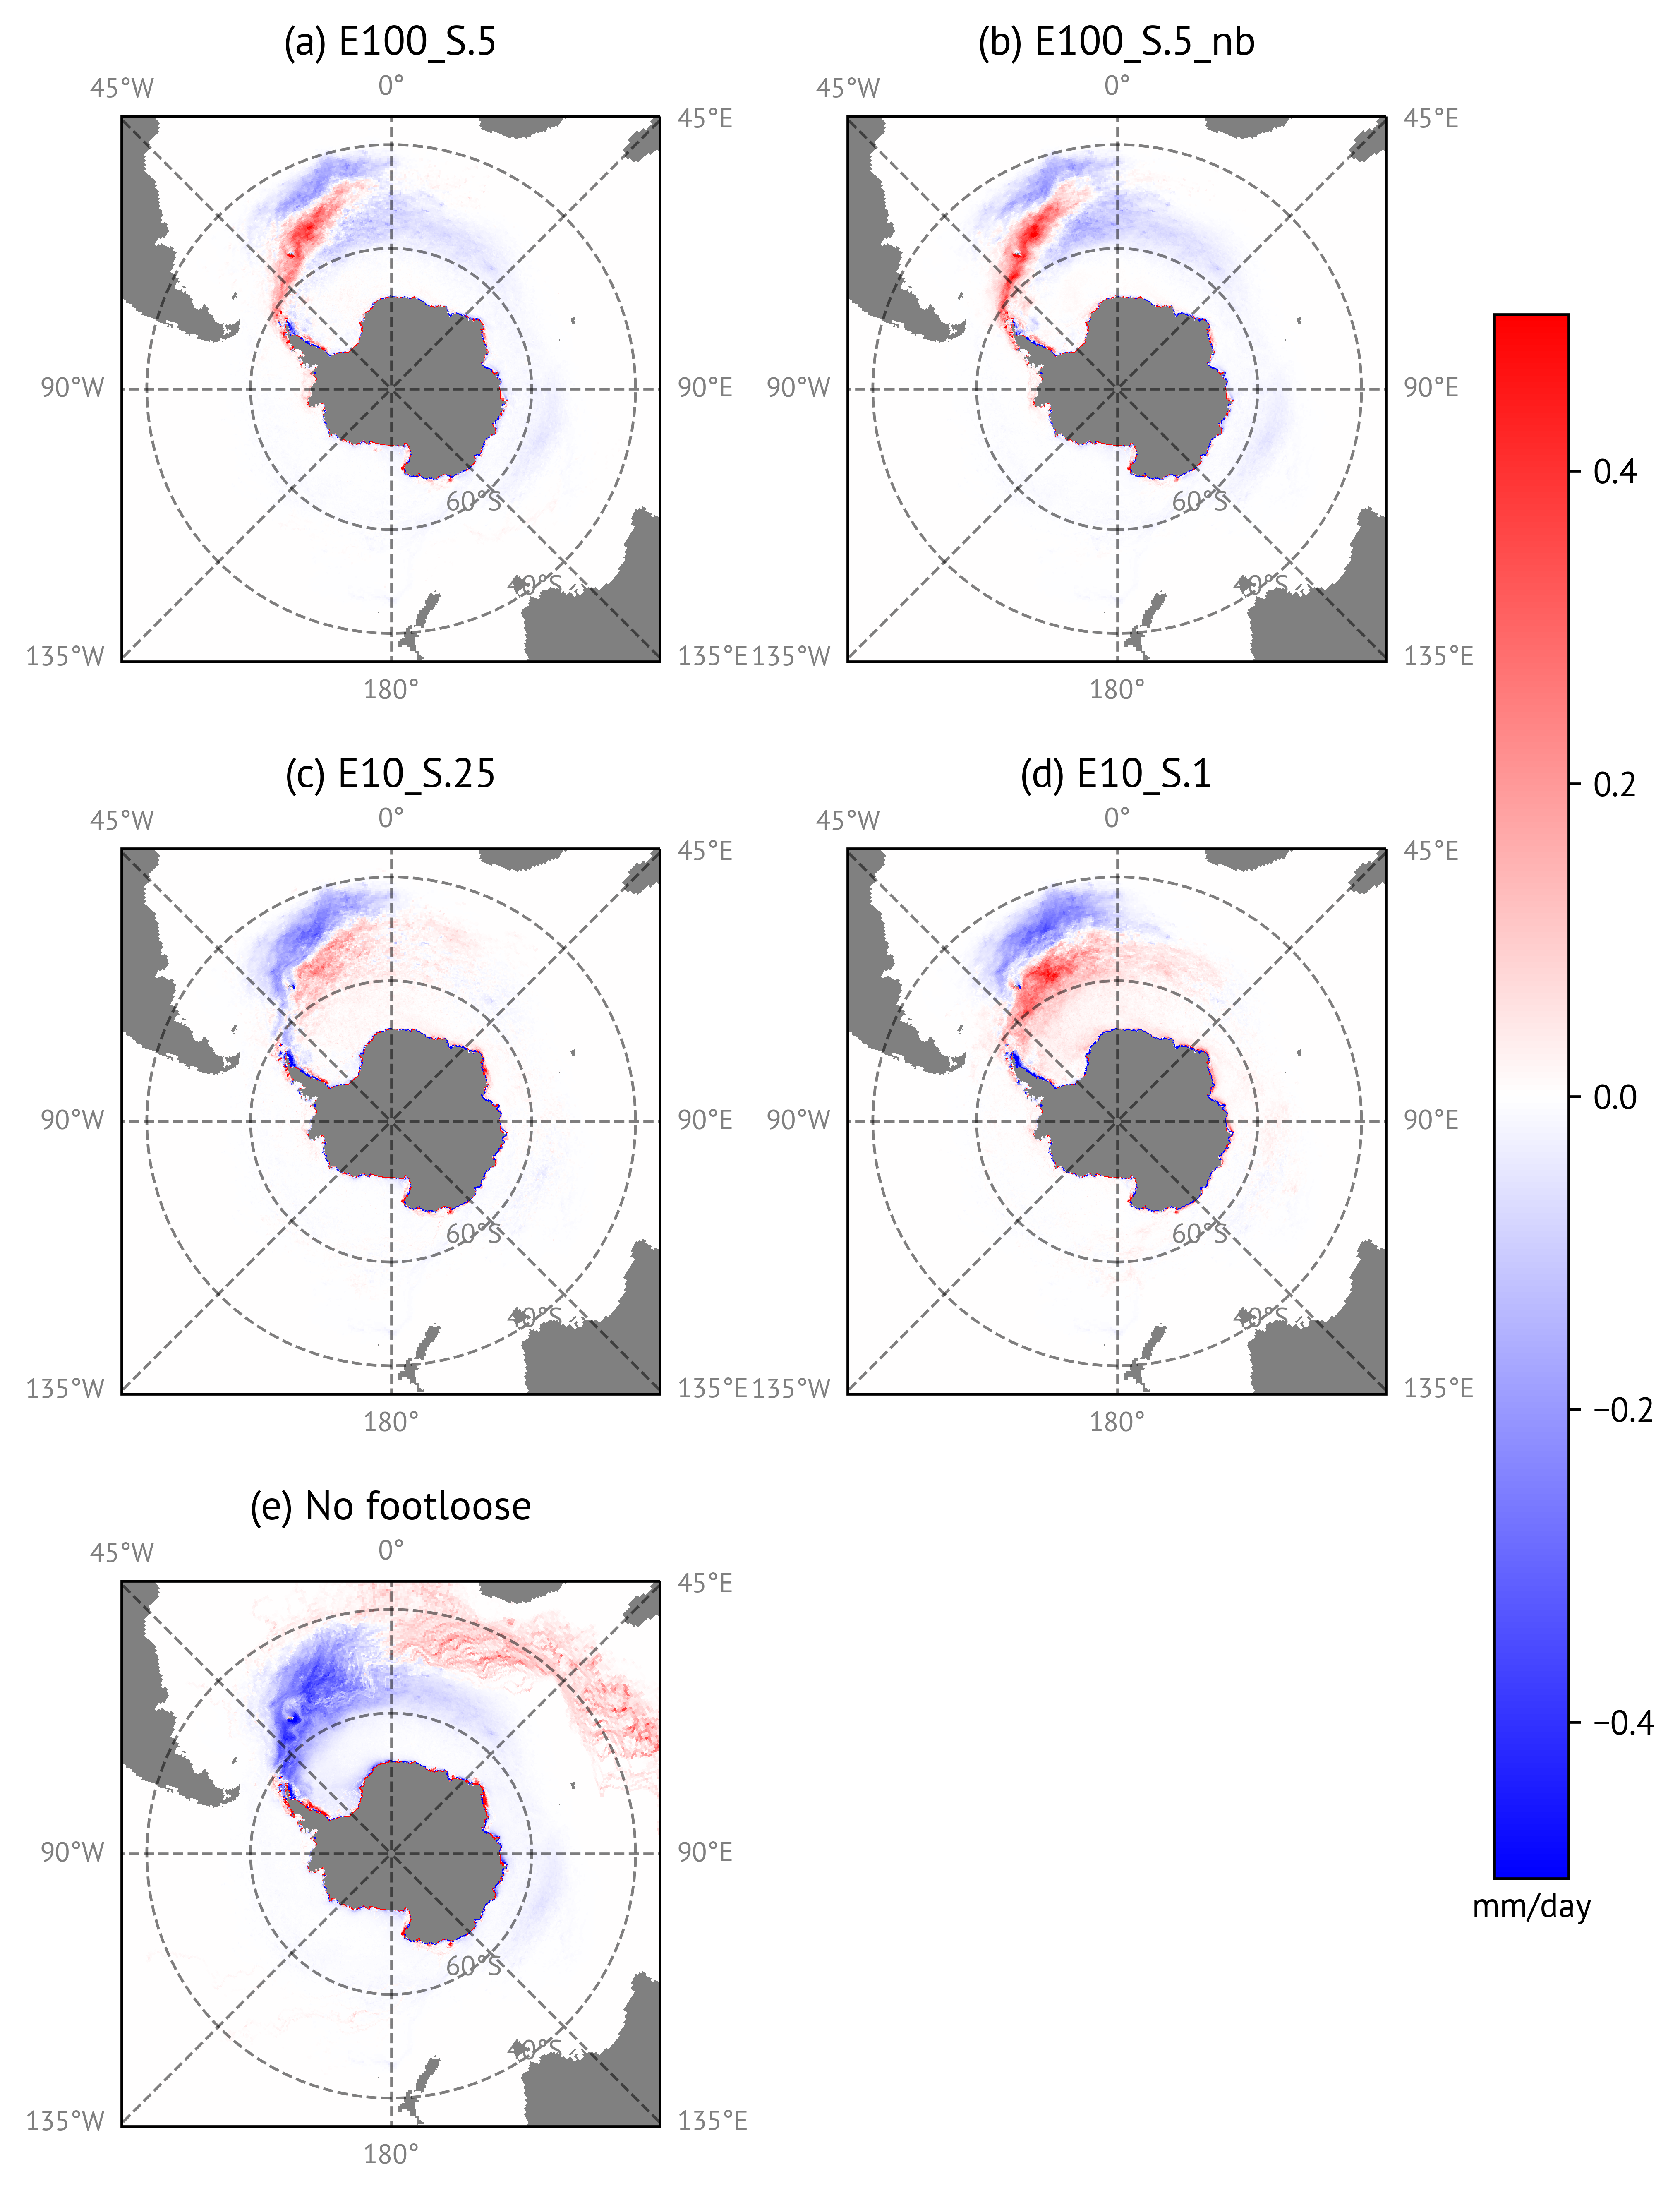

In [16]:
#PLOT MELT ANTARCTICA

extent=[-300, 60, -35, -115]
cmap='binary' #background colormap
cmin=0; cmax=1
subplot_kws=dict(projection=ccrs.SouthPolarStereo(central_longitude=0.),facecolor='grey')

logplot = False #True
override_bounds = True
copymarkbounds=False
keepbounds=False

#var='melt'; cb_label='mm/day'
#var='fl_parent_melt'; cb_label='mm/day'
#var='fl_child_melt'; cb_label='mm/day'
var='diff'; cb_label='mm/day'
#var='si_diff'; cb_label='concentration'
#var='sst_diff'; cb_label='$^{\circ}$C'
#var='melt_by_class_1'
#var='melt_by_class_2'
#var='melt_by_class_3'
#var='melt_by_class_4'
#var='melt_by_class_5'
#var='melt_by_class_6'
#var='melt_by_class_7'
#var='melt_by_class_8'
#var='melt_by_class_9'
#var='melt_by_class_10'
#var='cn'; cb_label='concentration'
#var='mass'
#var='sst'; cb_label='$^{\circ}$C'

cmin_override = 0; cmax_override = 0.0025
#cmin_override = 1e-5; cmax_override = 1e-2

#var= 'tot_melt_buoy'; cb_label='mm/day'
#var= 'tot_melt_eros'; cb_label='mm/day'
#var= 'tot_melt_conv'; cb_label='mm/day'
cmin_override=1e-8
cmax_override=1e-5

# if logplot:
#     var='logmelt'
minval=1e-32
    
if (var=='fl_parent_melt') | (var=='fl_child_melt'):
    inc_all2=False
else:
    inc_all2=inc_all


minp=1;#0; #5
maxp=99 #min and max data percentiles, which specify range of data to plot

if (var=='sst'):
    cmin_override = -2; cmax_override = 10   
elif (var=='cn'):
    cmin_override = 0; cmax_override = 1; 
    
if keepbounds:
    cmin2 = cmin2; cmax2 = cmax2
elif override_bounds:
    cmin2 = cmin_override; cmax2 = cmax_override
else:
    
    if ((var=='virtual_area') | (var=='mass')):
        np1= np.nanpercentile(g1s[var].where(g1s[var]>0),[minp,maxp]); np2= np.nanpercentile(g2s[var].where(g2s[var]>0),[minp,maxp]); np3= np.nanpercentile(g3s[var].where(g3s[var]>0),[minp,maxp]); np4= np.nanpercentile(g4s[var].where(g4s[var]>0),[minp,maxp])
        if inc_all2:
            np5= np.nanpercentile(g5s[var].where(g5s[var]>0),[minp,maxp]); np6= np.nanpercentile(g6s[var].where(g6s[var]>0),[minp,maxp]);     
    else:
        np1= np.nanpercentile(g1s[var],[minp,maxp]); np2= np.nanpercentile(g2s[var],[minp,maxp]); np3= np.nanpercentile(g3s[var],[minp,maxp]); np4= np.nanpercentile(g4s[var],[minp,maxp])
        if inc_all2:
            np5= np.nanpercentile(g5s[var],[minp,maxp]); np6= np.nanpercentile(g6s[var],[minp,maxp]);
        
    if inc_all2:
        cmin2 = np.min([np1,np2,np3,np4,np5,np6]); cmax2 = np.max([np1,np2,np3,np4,np5,np6])
    else:
        cmin2 = np.min([np1,np2,np3,np4]); cmax2 = np.max([np1,np2,np3,np4])

plt.rcParams['figure.figsize']=[5,9]
             
if inc_all2:
    fig, axes = plt.subplots(3,2, sharex=True, sharey=True, subplot_kw=subplot_kws,figsize=(6, 9))
else:
    fig, axes = plt.subplots(2,2, sharex=True, sharey=True, subplot_kw=subplot_kws,figsize=(6, 6))
#cmap=plt.get_cmap('viridis')
cmap = copy.copy(plt.cm.get_cmap("coolwarm"))
cmap = copy.copy(plt.cm.get_cmap("gnuplot2"))
#if cmin2<1e-32:
#    cmin2=1e-32
#cmap.set_under('w')

if logplot:
    N=9
    if copymarkbounds:
        cmin2=max(cmin2,1e-5)
        cmin2=1e-5
        cmax2=10**(-0.5) #35 #min(cmax2,10**(-0.5))
        N=9
    elif override_bounds:
        N=9
        cmin2=max(cmin2,1e-5)
        cmin2=1e-5
        cmax2=10#max(cmax2,1)
        cmax2=10**-0.5
        #cmin2=10**-4
        #cmax2=10**0
        #N=8
    
    cmin2=max(cmin2,minval)
    
#     if override_bounds:
#         minval=1e-32
#         cmin2=max(cmin2,1e-8)
#         cmin2 = cmin_override; cmax2 = cmax_override; N=9

    print('cmin',cmin2,'cmax',cmax2)
    colors=np.array([(230,230,250),(124,162,221),(44,133,202),(15,192,127),(63,221,64),(189,221,13),(221,126,0),(221,0,0)])
    cmap = LinearSegmentedColormap.from_list('segmap', colors/255, N=N)
    cmap.set_under('w')
    print('cmin',cmin2,'cmax',cmax2)
    m_p1 = g1s[var].where(g1s[var]!=0,minval).plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_p2 = g2s[var].where(g2s[var]!=0,minval).plot.pcolormesh(ax=axes[0,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_p3 = g3s[var].where(g3s[var]!=0,minval).plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_p4 = g4s[var].where(g4s[var]!=0,minval).plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    if inc_all2:
        m_p5 = g5s[var].where(g5s[var]!=0,minval).plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
        m_p6 = g6s[var].where(g6s[var]!=0,minval).plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))

else:
    
    if ((var=='diff') | (var=='si_diff') | (var=='sst_diff')):
        cmap = copy.copy(plt.cm.get_cmap("bwr"))
        if (var=='diff'):
            cmin2=-0.5; cmax2=0.5
        elif (var=='si_diff'):
            cmin2=-0.02; cmax2=0.02
        elif (var=='sst_diff'):
            cmin2=-0.25; cmax2=0.25
        #cmax2=0.02
        divnorm=mcolors.TwoSlopeNorm(vmin=cmin2, vcenter=0., vmax=cmax2)
        m_p1 = g1s[var].plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm)
        m_p2 = g2s[var].plot.pcolormesh(ax=axes[0,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm)
        m_p3 = g3s[var].plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm)
        m_p4 = g4s[var].plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm)
        if inc_all2:
            m_p5 = g5s[var].plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm)
            m_p6 = g6s[var].plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm)
    else:
        if var=='cn':
            cmap = copy.copy(plt.cm.get_cmap("Blues"))
        m_p1 = g1s[var].plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
        m_p2 = g2s[var].plot.pcolormesh(ax=axes[0,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
        m_p3 = g3s[var].plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
        m_p4 = g4s[var].plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
        if inc_all2:
            m_p5 = g5s[var].plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
            m_p6 = g6s[var].plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)

print('cmin',cmin2,'cmax',cmax2)

g1=plotformatting(axes[0,0])
g2=plotformatting(axes[0,1])
g3=plotformatting(axes[1,0])
g4=plotformatting(axes[1,1])
if inc_all2:
    g5=plotformatting(axes[2,0])
    g6=plotformatting(axes[2,1])
        
titlesize=12; titlepad=12
m_p1.axes.set_title('(a) '+rname_a, size=titlesize)#, pad=titlepad)
m_p2.axes.set_title('(b) '+rname_b, size=titlesize)#, pad=titlepad)
m_p3.axes.set_title('(c) '+rname_c, size=titlesize)#, pad=titlepad)
m_p4.axes.set_title('(d) '+rname_d, size=titlesize)#, pad=titlepad)
if inc_all2:
    m_p5.axes.set_title('(e) '+rname_e, size=titlesize)#, pad=titlepad)
    m_p6.axes.set_title('(f) '+rname_f, size=titlesize)#, pad=titlepad)

if ((var=='diff') | (var=='si_diff') | (var=='sst_diff')):
    axes[2,1].set_visible(False)
#fig.subplots_adjust(hspace=0.1,wspace=0.04)
#thelabel=var #+ ' flux (mm/day)'
#cbarlabels=[1e-5,1e-4,1e-4,]
#fig.colorbar(m_p1, ax=axes.ravel().tolist(), shrink=0.75, location='right', label=thelabel) #label='iceberg melt flux (mm/day)')
#cb=plt.colorbar(m_p1, ax=axes.ravel().tolist(), shrink=0.75, location='right')
#cb.set_label(label=thelabel,size=20)
#cb.ax.tick_params(labelsize=15)

plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.15, 0.05, 0.7]) #right, up, width, height
b=fig.colorbar(m_p4, cax=cbar_ax) 
b.ax.set_xlabel(cb_label)

In [17]:
def fixlatlabel_gl(gl):

    gl.x_inline=False
    gl.y_inline=False
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.ylabel_style = {'size': 15, 'color': 'gray'}
    gl.rotate_labels = False
    plt.draw()
    return gl

def plotformatting_n(mp,ax):
    
    dir_labels=True
    
    xticks=[-75,-50,-25,0]; yticks=[45,60]  
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    bound_in_target = proj_to_data.transform_path(boundary_path)
    ax.set_extent(extent2, crs=ccrs.PlateCarree())
    ax.set_boundary(bound_in_target)
    g=ax.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True,x_inline=False, y_inline=False,xlocs=xticks,ylocs=yticks)
    g.top_labels=False; g.right_labels=False; g.rotate_labels=False
    g.xformatter=LongitudeFormatter(direction_label=dir_labels); g.yformatter=LatitudeFormatter(direction_label=dir_labels)
    g.xlabel_style = {'size': 8, 'color': 'gray'}; g.ylabel_style = {'size': 8, 'color': 'gray'}
    return mp,g
    

In [18]:
plt.rcParams['figure.dpi'] = 600  #72 originally
#plt.rcParams['figure.figsize']=[8,12]
#plt.rcParams['figure.figsize']=[6.5,9]
plt.rcParams["font.family"]='PT Sans'

cmin 1e-05 cmax 1


Text(0.5, 0, 'mm/day')

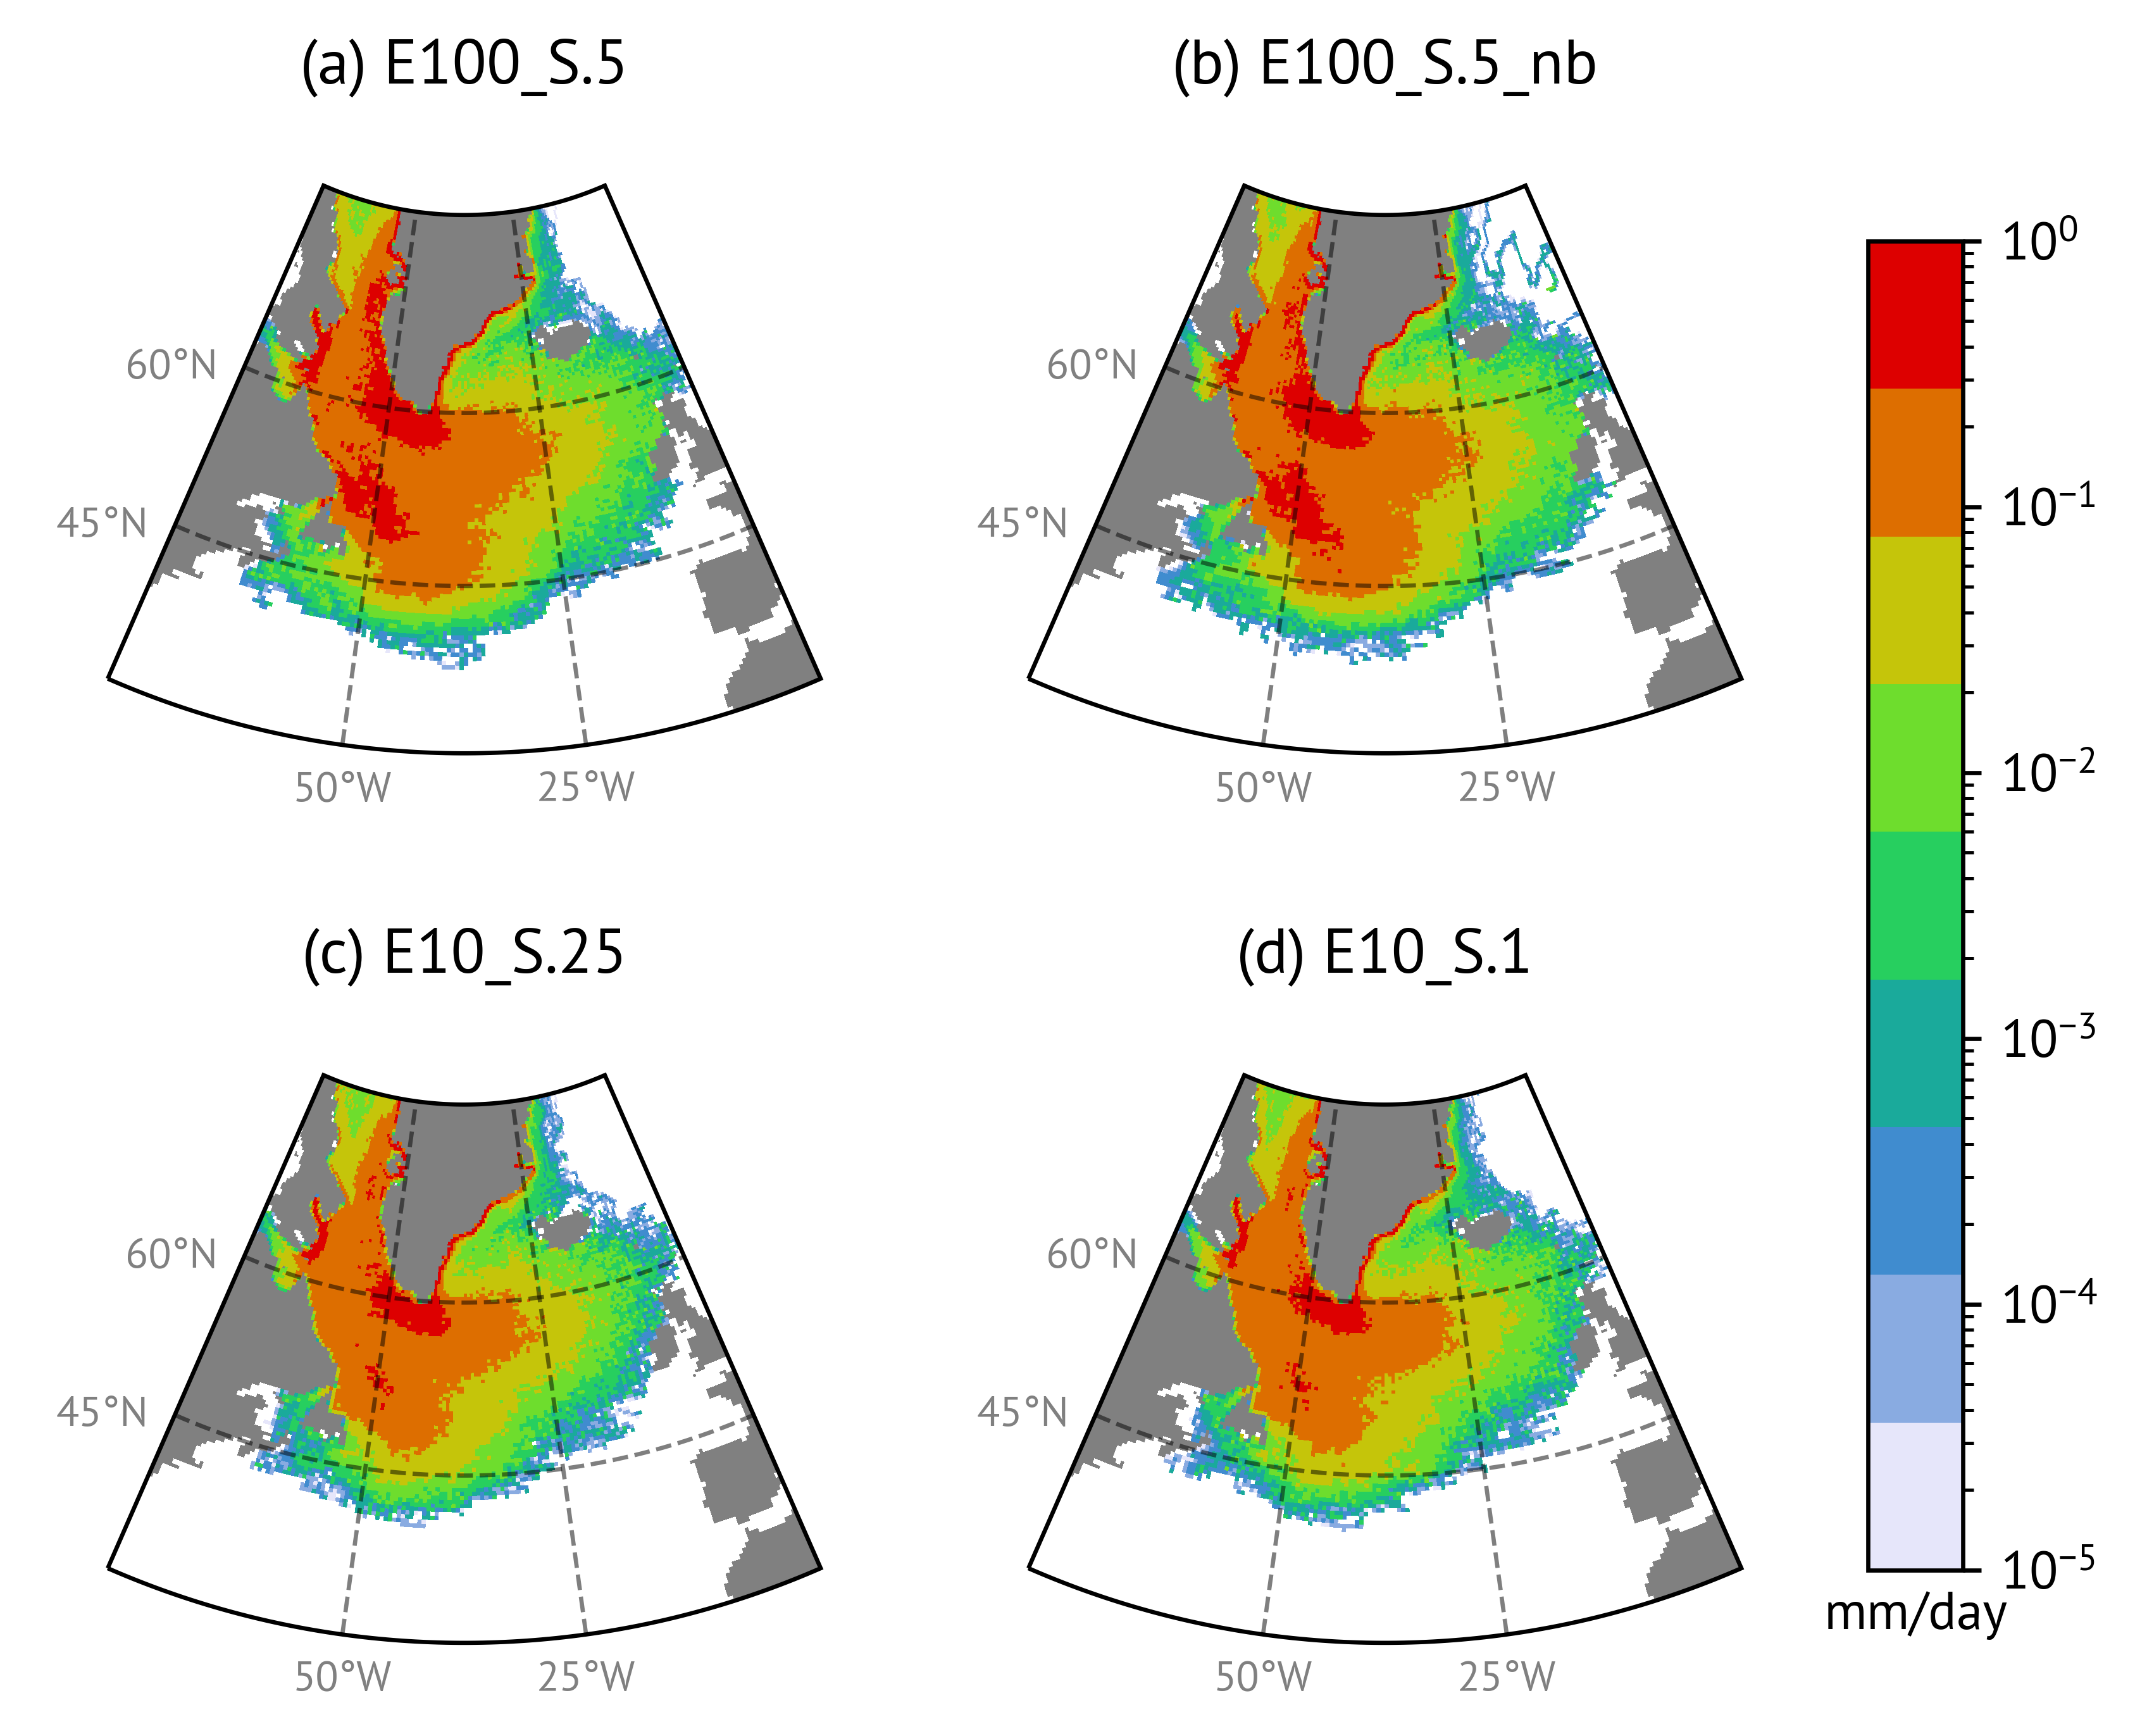

In [25]:
#PLOT MELT GREENLAND
rname_e='No footloose'

logplot = True
override_bounds = True
copymarkbounds=False

midlon = -37.5
maxlon = midlon + 37.5
minlon = midlon-37.5
minlat = 30
maxlat = 75
midlat = (minlat + maxlat)/2

extent=[minlon, maxlon, minlat, maxlat]
extent2=[minlon-5, maxlon+5, minlat-5, maxlat]
cmap='binary' #background colormap
cmin=0; cmax=1

#proj=ccrs.LambertConformal(central_longitude=midlon,central_latitude=midlat)

#subplot_kwn=dict(projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat),facecolor='grey')
subplot_kwn=dict(projection=ccrs.LambertConformal(central_longitude=midlon, central_latitude=midlat),facecolor='grey')
bottom_x=np.vstack(np.linspace(minlon,maxlon,100)); bottom_y=bottom_x*0+minlat
top_x=np.vstack(np.linspace(maxlon,minlon,100)); top_y=top_x*0+maxlat
lons=np.vstack((bottom_x,top_x)); lats=np.vstack((bottom_y,top_y))
boundary_path=np.hstack((lons,lats))
boundary_path = mpath.Path(boundary_path)


#var='melt'; cb_label='mm/day'
#var='diff'; cb_label='mm/day'
var='fl_parent_melt'; cb_label='mm/day'
#var='fl_child_melt'; cb_label='mm/day'
#var='sst'; cb_label='$^{\circ}$C'
#var='cn'; cb_label='concentration'; cmin_override=0; cmax_override=1; logplot=False
#var= 'melt_buoy'; cb_label='mm/day'
#var= 'melt_eros'; cb_label='mm/day'
# var= 'melt_conv'; cb_label='mm/day'
# cmin_override=1e-8
# cmax_override=8e-6

#var= 'tot_melt_buoy'; cb_label='mm/day'
#var= 'tot_melt_eros'; cb_label='mm/day'
#var= 'tot_melt_conv'; cb_label='mm/day'
cmin_override=1e-8
cmax_override=1e-5


#if logplot:
#    var='logmelt'

if (var=='diff'):
    cmin_override = -0.3; cmax_override = 0.3
    #cmin_override = -0.02; cmax_override = 0.02
else:
    cmin_override = 10**-5; cmax_override = 10**0
    N=9
#cmin_override = cmin2; cmax_override = cmax2

if (var=='sst'):
    cmin_override = -2; cmax_override = 10

minp=0.75; maxp=99 #9 #.25 #min and max data percentiles, which specify range of data to plot
#cmap='viridis'

minval=1e-32
    
if (var=='fl_parent_melt') | (var=='fl_child_melt') | (var=='diff'):
    inc_all2=False
else:
    inc_all2=inc_all

if override_bounds:
    cmin2 = cmin_override; cmax2 = cmax_override
else:
    np1= np.nanpercentile(g1s[var],[minp,maxp]); np2= np.nanpercentile(g2s[var],[minp,maxp]); np3= np.nanpercentile(g3s[var],[minp,maxp]); np4= np.nanpercentile(g4s[var],[minp,maxp])
    if inc_all2:
        np5= np.nanpercentile(g5s[var],[minp,maxp]); np6= np.nanpercentile(g6s[var],[minp,maxp]);
        cmin2 = np.min([np1,np2,np3,np4,np5,np6]); cmax2 = np.max([np1,np2,np3,np4,np5,np6])
    else:
        cmin2 = np.min([np1,np2,np3,np4]); cmax2 = np.max([np1,np2,np3,np4])

    print('cmin',cmin2,'cmax',cmax2)
        
        
#plt.rcParams['figure.figsize']=[6.5,9]  

if inc_all2:
    plt.rcParams['figure.figsize']=[5,7.5]
    fig, axes = plt.subplots(3,2, sharex=True, sharey=True, subplot_kw=subplot_kwn, figsize=(5, 7.5))
else:
    plt.rcParams['figure.figsize']=[5,5]
    fig, axes = plt.subplots(2,2, sharex=True, sharey=True, subplot_kw=subplot_kwn ,figsize=(5,5)) #12, 10 
    
#cmap=plt.get_cmap('viridis')
#cmap = copy.copy(plt.cm.get_cmap("coolwarm"))
cmap = copy.copy(plt.cm.get_cmap("bwr"))

#if cmin2<1e-32:
#    cmin2=1e-32
#cmap.set_under('w')

if logplot:
    cmin2=max(cmin2,1e-8)
    #cmin2=max(cmin2,1e-5)
    if copymarkbounds:
        cmin2=1e-5
        cmax2=min(cmax2,10**(-0.5))
        N=9
    else: 
        #cmax2=10#max(cmax2,1)
        #cmax2=1
        N=9
    print('cmin',cmin2,'cmax',cmax2)

    colors=np.array([(230,230,250),(124,162,221),(44,133,202),(15,192,127),(63,221,64),(189,221,13),(221,126,0),(221,0,0)])
    cmap = LinearSegmentedColormap.from_list('segmap', colors/255, N=N)
    cmap.set_under('w')
    m_p1 = g1n[var].where(g1n[var]!=0,minval).plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_p2 = g2n[var].where(g2n[var]!=0,minval).plot.pcolormesh(ax=axes[0,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_p3 = g3n[var].where(g3n[var]!=0,minval).plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    m_p4 = g4n[var].where(g4n[var]!=0,minval).plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
    if inc_all2:
        m_p5 = g5n[var].where(g5n[var]!=0,minval).plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
        m_p6 = g6n[var].where(g6n[var]!=0,minval).plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin2,vmax=cmax2))
else:
            
    if ((var=='diff') | (var=='si_diff') | (var=='sst_diff')):
        
        cmap = copy.copy(plt.cm.get_cmap("bwr"))
        if (var=='diff'):
            cmin2=-0.3; cmax2=0.3
        elif (var=='si_diff'):
            cmin2=-0.02; cmax2=0.02
        elif (var=='sst_diff'):
            cmin2=-0.25; cmax2=0.25
        
        divnorm=mcolors.TwoSlopeNorm(vmin=cmin2, vcenter=0., vmax=cmax2)
        m_p1 = g1n[var].plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
        m_p2 = g2n[var].plot.pcolormesh(ax=axes[0,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
        m_p3 = g3n[var].plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
        m_p4 = g4n[var].plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
        if inc_all2:
            m_p5 = g5n[var].plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
            m_p6 = g6n[var].plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
    else:
        cmap=copy.copy(plt.cm.get_cmap("gnuplot2"))
#         if cmin2<0.0001:
#             cmin2=0.0001
#             cmap.set_under('w')
        #divnorm=mcolors.TwoSlopeNorm(vmin=cmin2, vcenter=0.5*(cmin2+cmax2), vmax=cmax2)
   
        print('cmin',cmin2,'cmax',cmax2)
        m_p1 = g1n[var].plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
        m_p2 = g2n[var].plot.pcolormesh(ax=axes[0,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
        m_p3 = g3n[var].plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
        m_p4 = g4n[var].plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
        if inc_all2:
            m_p5 = g5n[var].plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)
            m_p6 = g6n[var].plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,vmin=cmin2,vmax=cmax2)

m_p1,g1=plotformatting_n(m_p1,axes[0,0])
m_p2,g2=plotformatting_n(m_p2,axes[0,1])
m_p3,g3=plotformatting_n(m_p3,axes[1,0])
m_p4,g4=plotformatting_n(m_p4,axes[1,1])

if inc_all2:
    m_p5,g5=plotformatting_n(m_p5,axes[2,0])
    m_p6,g6=plotformatting_n(m_p6,axes[2,1])

titlesize=12; titlepad=18
m_p1.axes.set_title('(a) '+rname_a, size=titlesize, pad=titlepad)
m_p2.axes.set_title('(b) '+rname_b, size=titlesize, pad=titlepad)
m_p3.axes.set_title('(c) '+rname_c, size=titlesize, pad=titlepad)
m_p4.axes.set_title('(d) '+rname_d, size=titlesize, pad=titlepad)
if inc_all2:
    m_p5.axes.set_title('(e) '+rname_e, size=titlesize, pad=titlepad)
    m_p6.axes.set_title('(f) '+rname_f, size=titlesize, pad=titlepad)

if inc_all2:
    axes[2,1].set_visible(False)

plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.15, 0.05, 0.7]) #right, up, width, height
b=fig.colorbar(m_p4, cax=cbar_ax) 
b.ax.set_xlabel(cb_label)

In [26]:
check_scaling=True
gton_per_year=True
var='fl_parent_melt'
var2='melt'

if check_scaling:
    if gton_per_year:
        scale2=1/scale*1e-12*60*60*24*365.15
    else:
        scale2=1

    print('g1s[melt].sum()',100*(g1s[var]*scale2*g1s['area']).sum()/(g1s[var2]*scale2*g1s['area']).sum())
    print('g2s[melt].sum()',100*(g2s[var]*scale2*g2s['area']).sum()/(g2s[var2]*scale2*g2s['area']).sum())
    print('g3s[melt].sum()',100*(g3s[var]*scale2*g3s['area']).sum()/(g3s[var2]*scale2*g3s['area']).sum())
    print('g4s[melt].sum()',100*(g4s[var]*scale2*g4s['area']).sum()/(g4s[var2]*scale2*g4s['area']).sum())
    if inc_all:
        print('g5s[melt].sum()',100*(g5s[var]*scale2*g5s['area']).sum()/(g5s[var2]*scale2*g5s['area']).sum())
        print('g6s[melt].sum()',100*(g6s[var]*scale2*g6s['area']).sum()/(g6s[var2]*scale2*g6s['area']).sum())
    print('')
    print('g1n[melt].sum()',100*(g1n[var]*scale2*g1n['area']).sum()/(g1n[var2]*scale2*g1n['area']).sum())
    print('g2n[melt].sum()',100*(g2n[var]*scale2*g2n['area']).sum()/(g2n[var2]*scale2*g2n['area']).sum())
    print('g3n[melt].sum()',100*(g3n[var]*scale2*g3n['area']).sum()/(g3n[var2]*scale2*g3n['area']).sum())
    print('g4n[melt].sum()',100*(g4n[var]*scale2*g4n['area']).sum()/(g4n[var2]*scale2*g4n['area']).sum())
    if inc_all:
        print('g5n[melt].sum()',100*(g5n[var]*scale2*g5n['area']).sum()/(g5n[var2]*scale2*g5n['area']).sum())
        print('g6n[melt].sum()',100*(g6n[var]*scale2*g6n['area']).sum()/(g6n[var2]*scale2*g6n['area']).sum())

g1s[melt].sum() <xarray.DataArray ()>
array(30.15355828)
g2s[melt].sum() <xarray.DataArray ()>
array(30.08328143)
g3s[melt].sum() <xarray.DataArray ()>
array(39.45419255)
g4s[melt].sum() <xarray.DataArray ()>
array(19.24285065)
g5s[melt].sum() <xarray.DataArray ()>
array(100.)
g6s[melt].sum() <xarray.DataArray ()>
array(100.)

g1n[melt].sum() <xarray.DataArray ()>
array(82.69328139)
g2n[melt].sum() <xarray.DataArray ()>
array(82.80160874)
g3n[melt].sum() <xarray.DataArray ()>
array(60.02818208)
g4n[melt].sum() <xarray.DataArray ()>
array(58.41018405)
g5n[melt].sum() <xarray.DataArray ()>
array(100.)
g6n[melt].sum() <xarray.DataArray ()>
array(100.)


Text(0.5, 0, 'mm/day')

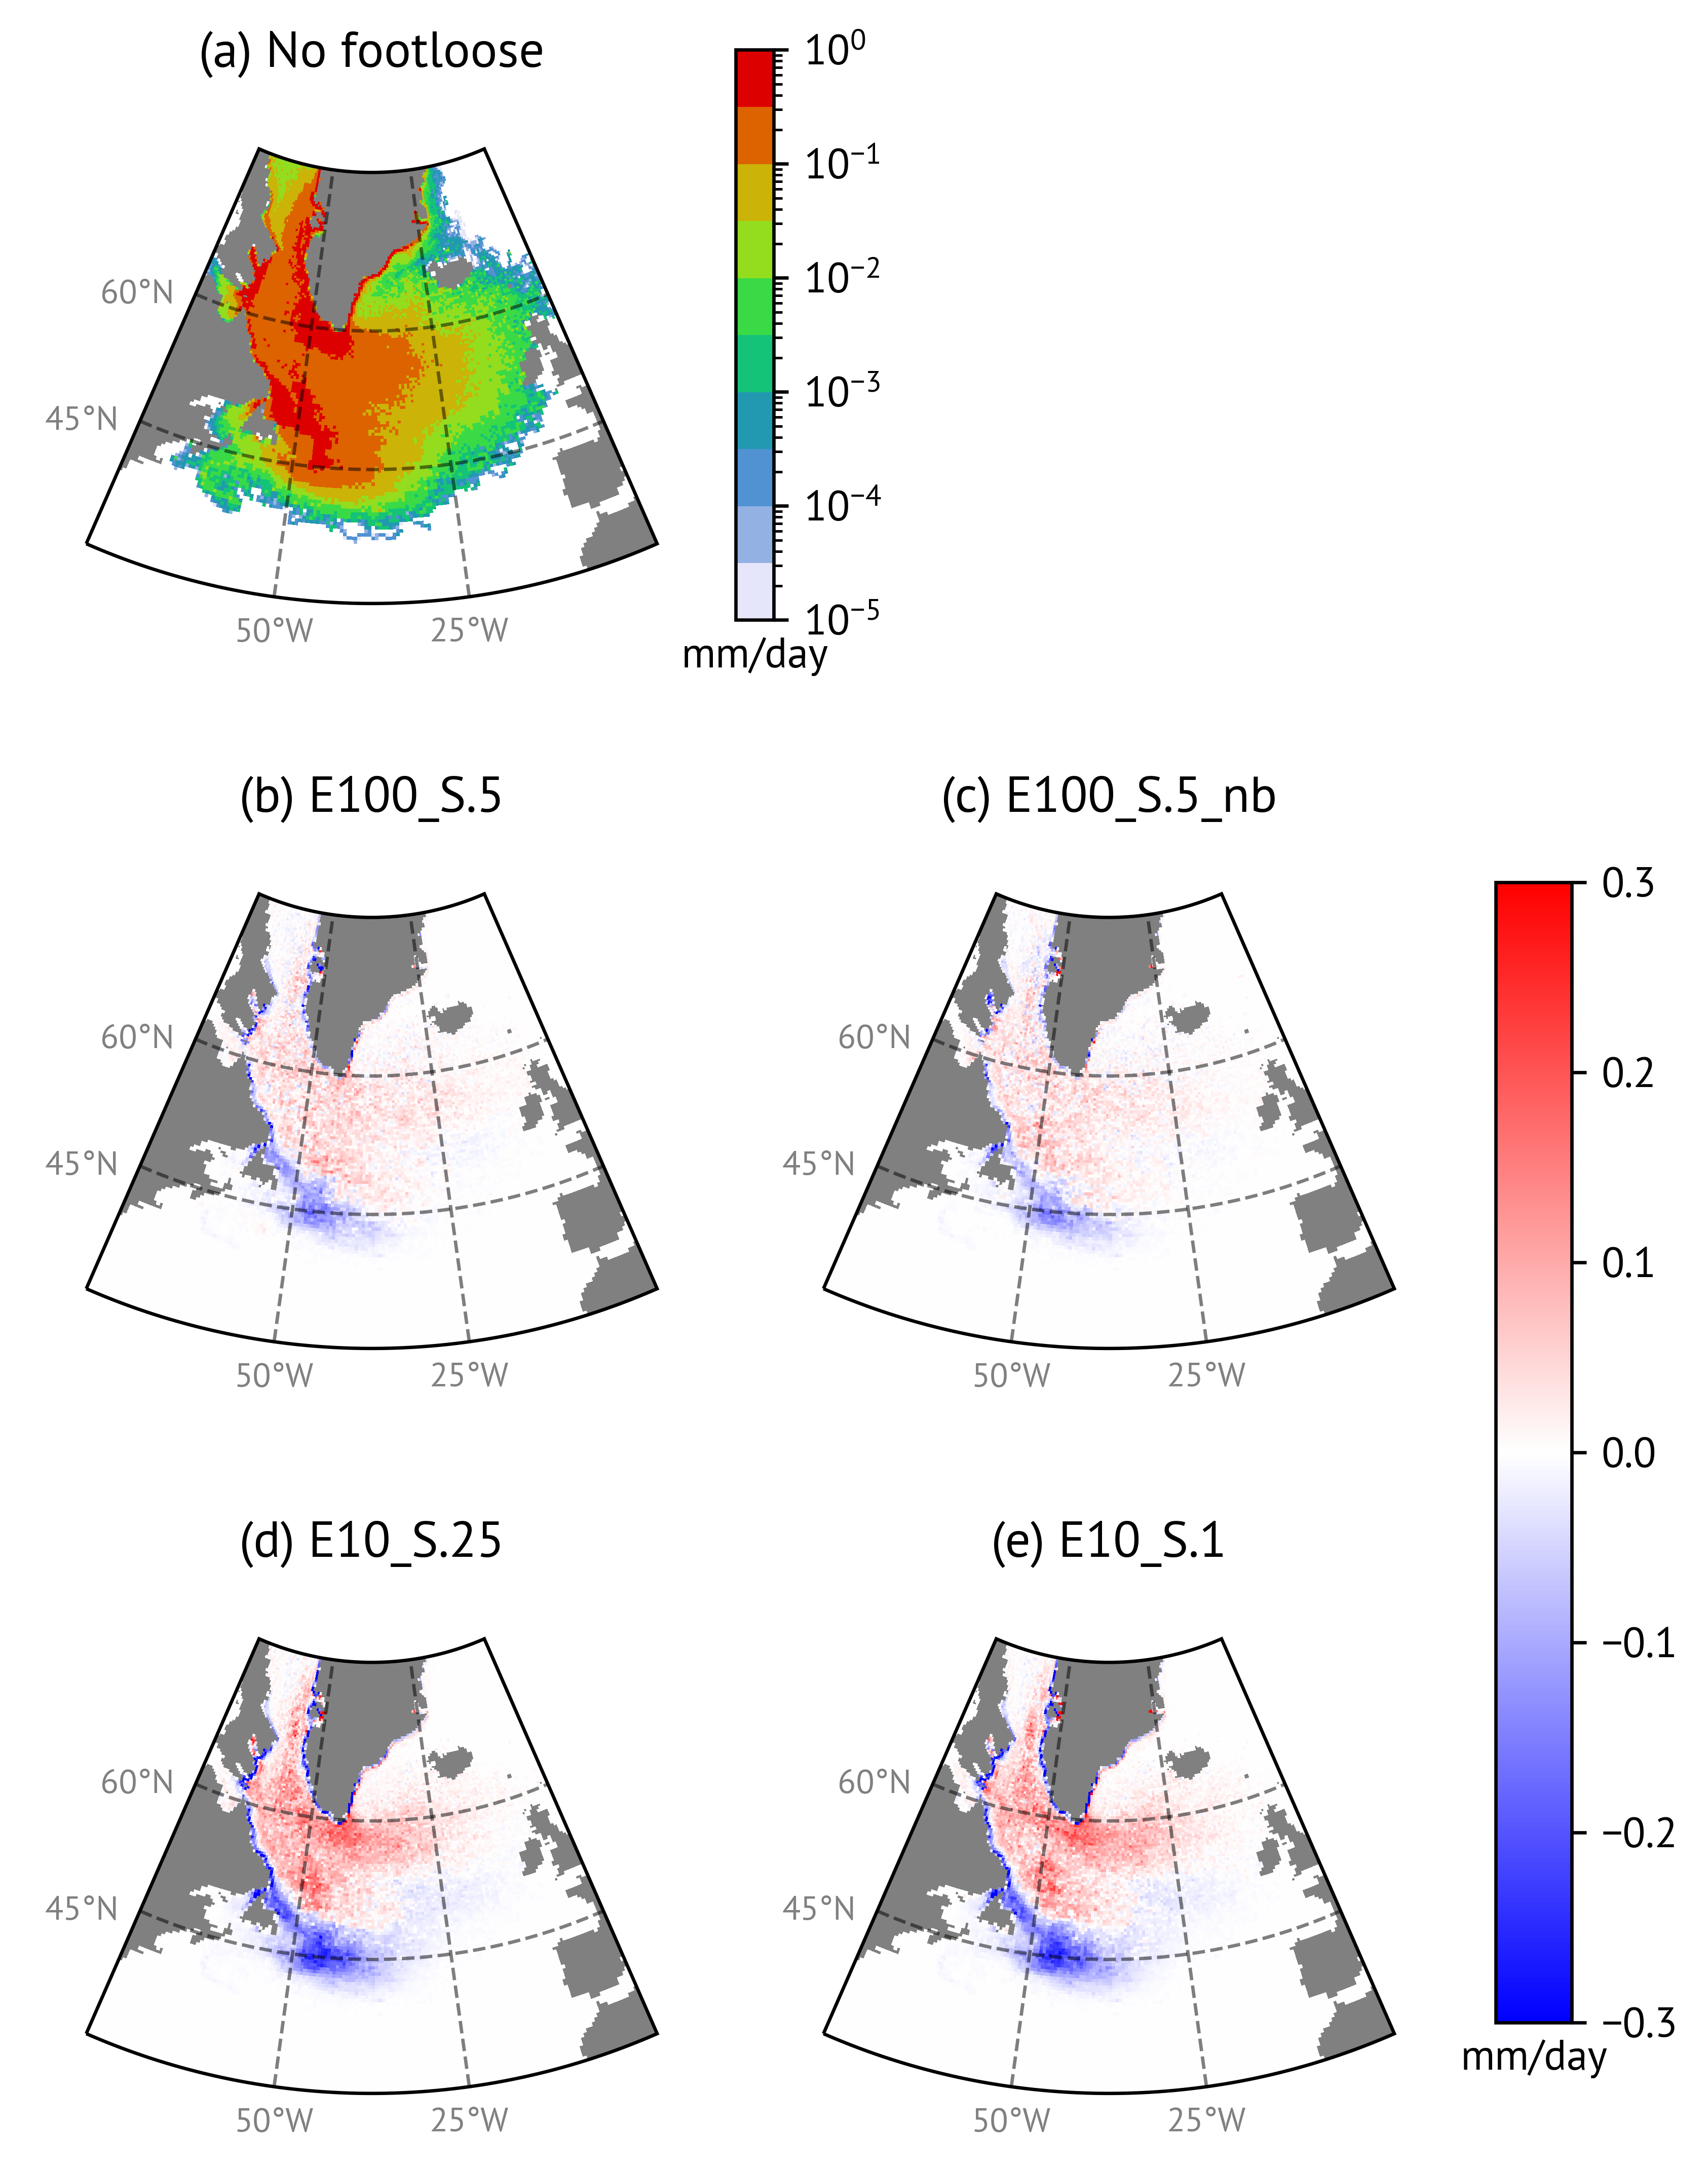

In [27]:
#PLOT MELT GREENLAND melt and diff
from matplotlib.gridspec import GridSpec

rname_e='No footloose'

logplot = True
override_bounds = True
copymarkbounds=False

midlon = -37.5
maxlon = midlon + 37.5
minlon = midlon-37.5
minlat = 30
maxlat = 75
midlat = (minlat + maxlat)/2

extent=[minlon, maxlon, minlat, maxlat]
extent2=[minlon-5, maxlon+5, minlat-5, maxlat]
cmap='binary' #background colormap
cmin=0; cmax=1

subplot_kwn=dict(projection=ccrs.LambertConformal(central_longitude=midlon, central_latitude=midlat),facecolor='grey')
bottom_x=np.vstack(np.linspace(minlon,maxlon,100)); bottom_y=bottom_x*0+minlat
top_x=np.vstack(np.linspace(maxlon,minlon,100)); top_y=top_x*0+maxlat
lons=np.vstack((bottom_x,top_x)); lats=np.vstack((bottom_y,top_y))
boundary_path=np.hstack((lons,lats))
boundary_path = mpath.Path(boundary_path)


var='melt'; cb_label='mm/day'; cmin = 10**-5; cmax = 10**0
var2='diff'; cb_label='mm/day'; cmin2 = -0.3; cmax2 = 0.3
#var='fl_parent_melt'; cb_label='mm/day'
#var='fl_child_melt'; cb_label='mm/day'
#var='sst'; cb_label='$^{\circ}$C'
#var='cn'; cb_label='concentration'; cmin_override=0; cmax_override=1; logplot=False

minval=1e-32

ww=5
hh=7.5
plt.rcParams['figure.figsize']=[ww,hh]
fig, axes = plt.subplots(3,2, sharex=True, sharey=True, subplot_kw=subplot_kwn, figsize=(ww, hh))

N=10
colors=np.array([(230,230,250),(124,162,221),(44,133,202),(15,192,127),(63,221,64),(189,221,13),(221,126,0),(221,0,0)])
cmap = LinearSegmentedColormap.from_list('segmap', colors/255, N=N)
cmap.set_under('w')
m_p5 = g5n[var].where(g5n[var]!=0,minval).plot.pcolormesh(ax=axes[0,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False, norm=mcolors.LogNorm(vmin=cmin,vmax=cmax))

cmap = copy.copy(plt.cm.get_cmap("bwr"))
divnorm=mcolors.TwoSlopeNorm(vmin=cmin2, vcenter=0., vmax=cmax2)
m_p1 = g1n[var2].plot.pcolormesh(ax=axes[1,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
m_p2 = g2n[var2].plot.pcolormesh(ax=axes[1,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
m_p3 = g3n[var2].plot.pcolormesh(ax=axes[2,0],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)
m_p4 = g4n[var2].plot.pcolormesh(ax=axes[2,1],cmap=cmap,transform=ccrs.PlateCarree(),add_labels=False,add_colorbar=False,norm=divnorm) #vmin=cmin2,vmax=cmax2)

m_p5,g5=plotformatting_n(m_p5,axes[0,0])
m_p1,g1=plotformatting_n(m_p1,axes[1,0])
m_p2,g2=plotformatting_n(m_p2,axes[1,1])
m_p3,g3=plotformatting_n(m_p3,axes[2,0])
m_p4,g4=plotformatting_n(m_p4,axes[2,1])

titlesize=12; titlepad=18
m_p5.axes.set_title('(a) '+rname_e, size=titlesize, pad=titlepad)
m_p1.axes.set_title('(b) '+rname_a, size=titlesize, pad=titlepad)
m_p2.axes.set_title('(c) '+rname_b, size=titlesize, pad=titlepad)
m_p3.axes.set_title('(d) '+rname_c, size=titlesize, pad=titlepad)
m_p4.axes.set_title('(e) '+rname_d, size=titlesize, pad=titlepad)

axes[0,1].set_visible(False)

plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.1, 0.05, 0.5]) #right, up, width, height
b=fig.colorbar(m_p4, cax=cbar_ax) 
b.ax.set_xlabel(cb_label)

cbar_ax0 = fig.add_axes([0.5, 0.715, 0.025, 0.25]) #right, up, width, height
b0=fig.colorbar(m_p5, cax=cbar_ax0) 
b0.ax.set_xlabel(cb_label)

